<a href="https://colab.research.google.com/github/Abhiji-th/edema-ards-classification/blob/main/covid_pneumonia_resnet50_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

2025-04-12 09:11:20.100102: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744449080.603651      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744449080.745006      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def load_data(image_size, labels, base_path):
    X = []
    Y = []
    for label in labels:
        folderPath = os.path.join(base_path, label)
        for img_name in os.listdir(folderPath):
            img_path = os.path.join(folderPath, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (image_size, image_size))
            X.append(img)
            Y.append(labels.index(label))
    return np.array(X), np.array(Y)

In [4]:
image_size = 224
labels = ['covid', 'pneumonia']
base_path = '/kaggle/input/covid-pneumonia-lus-images/covid_pneumonia'

# Load data
X, Y = load_data(image_size, labels, base_path)

# Step 1: Split into train + validation_temp and test
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)

# Step 2: Split validation_temp into validation and test
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

In [12]:
# Data Augmentation & Normalisation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    preprocessing_function=lambda x: (x - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]  # ImageNet normalization
)

In [13]:
val_datagen = ImageDataGenerator(
    preprocessing_function=lambda x: (x - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]
)

In [14]:
early_stop = EarlyStopping(
    monitor='val_loss',    # What to monitor (e.g., 'val_loss' or 'val_accuracy')
    patience=5,            # Number of epochs to wait before stopping after no improvement
    restore_best_weights=True  # Revert to best weights (optional but useful)
)

In [15]:
def build_and_train_model(base_model, X_train, Y_train, X_val, Y_val, X_test, Y_test, labels, model_name):
    # Custom top layers
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.4))  # Add dropout with 40% rate
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    start_time = time.time()
    history = model.fit(train_datagen.flow(X_train, Y_train, batch_size=32),
                        epochs=20,
                        validation_data=val_datagen.flow(X_val, Y_val),
                        callbacks=[early_stop])
    training_time = time.time() - start_time

    plt.figure(figsize=(14, 7))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy for {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure(figsize=(14, 7))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    model.save(f'lungultrasound_model_{model_name}.keras')

    test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=1)
    print(f"Final Test Accuracy: {test_accuracy:.4f}")
    print(f'Final Test Loss: {test_loss:.4f}')

    # Confusion Matrix and Classification Report
    Y_pred = model.predict(X_test)
    Y_pred_classes = (Y_pred > 0.5).astype(int)

    conf_matrix = confusion_matrix(Y_test, Y_pred_classes)
    class_report = classification_report(Y_test, Y_pred_classes, target_names=labels)

    print(f'Classification Report for {model_name}:')
    print(class_report)

    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    return history, training_time, conf_matrix, class_report, Y_test, Y_pred_classes

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 663ms/step - accuracy: 0.7478 - loss: 2.2944 - val_accuracy: 0.9798 - val_loss: 0.0439
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 324ms/step - accuracy: 0.9079 - loss: 0.6084 - val_accuracy: 1.0000 - val_loss: 0.0091
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 330ms/step - accuracy: 0.9295 - loss: 0.3001 - val_accuracy: 1.0000 - val_loss: 0.0114
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 334ms/step - accuracy: 0.9594 - loss: 0.1546 - val_accuracy: 1.0000 - val_loss: 0.0072
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 322ms/step - accuracy: 0.9548 - loss: 0.1531 - val_accuracy: 1.0000 - val_loss: 0.0048
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 338ms/step - accuracy: 0.9723 - loss: 0.0978 - val_accuracy: 1.0000 - val_loss: 0.0040
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 311ms/step - accuracy: 0.9691 - loss: 0.1014 - val_accuracy: 0.9899 - val_loss: 0.0307
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 313ms/step - accuracy: 0.9799 - loss: 0.0769 - val_accuracy: 0.989

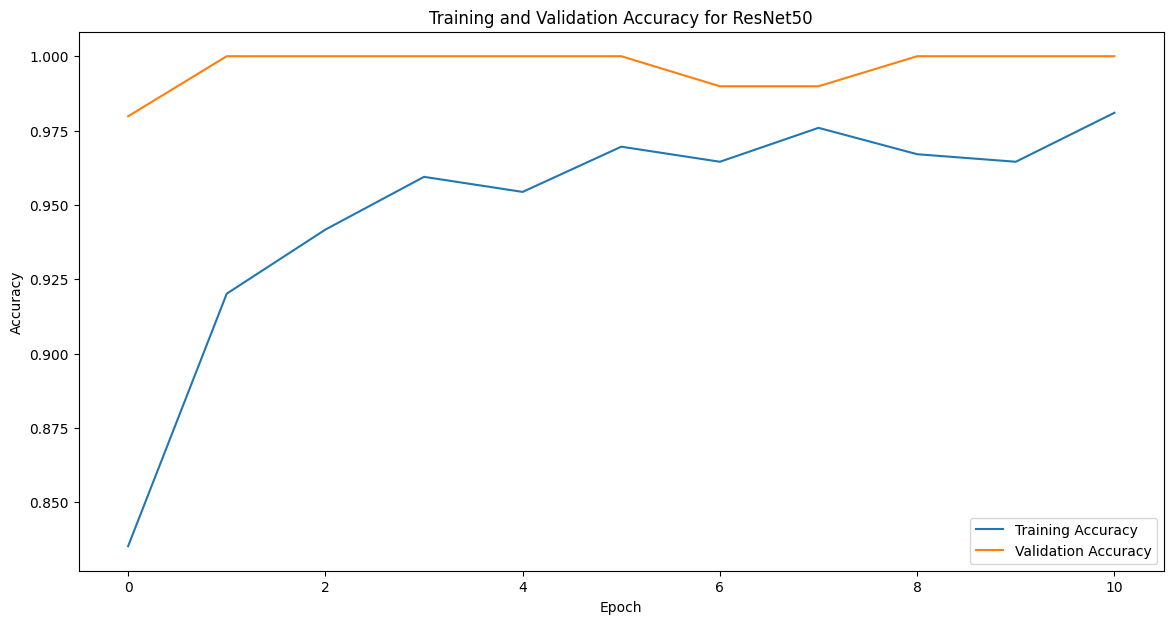

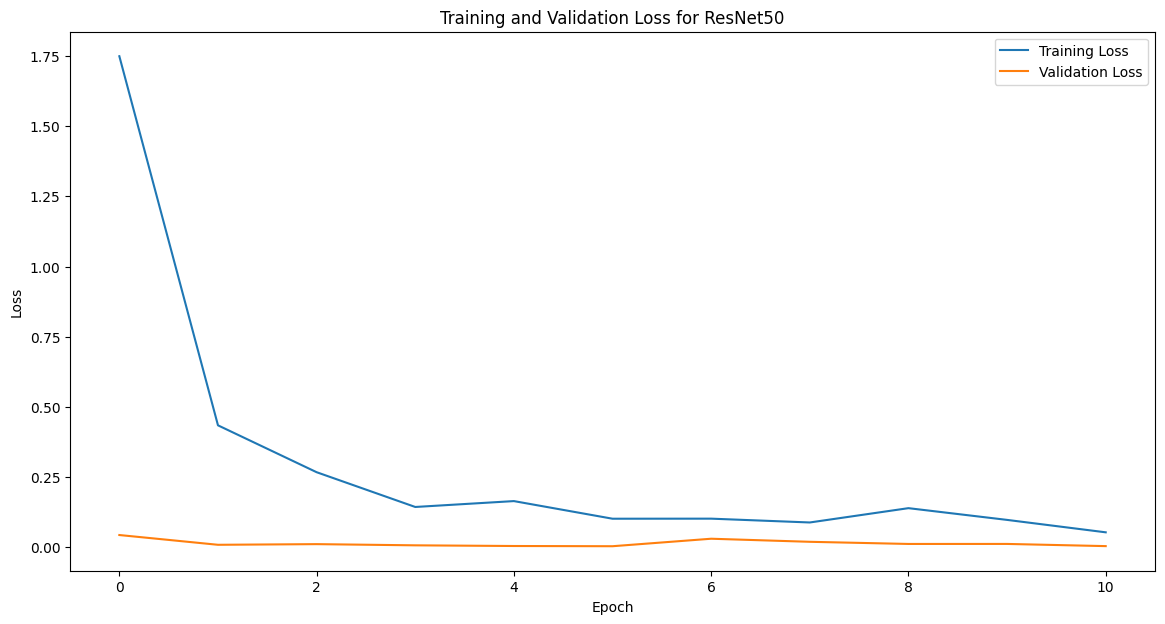

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 523ms/step - accuracy: 0.9785 - loss: 0.1001
Final Test Accuracy: 0.9697
Final Test Loss: 0.1151
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step 
Classification Report for ResNet50:
              precision    recall  f1-score   support

       covid       0.96      0.98      0.97        50
   pneumonia       0.98      0.96      0.97        49

    accuracy                           0.97        99
   macro avg       0.97      0.97      0.97        99
weighted avg       0.97      0.97      0.97        99



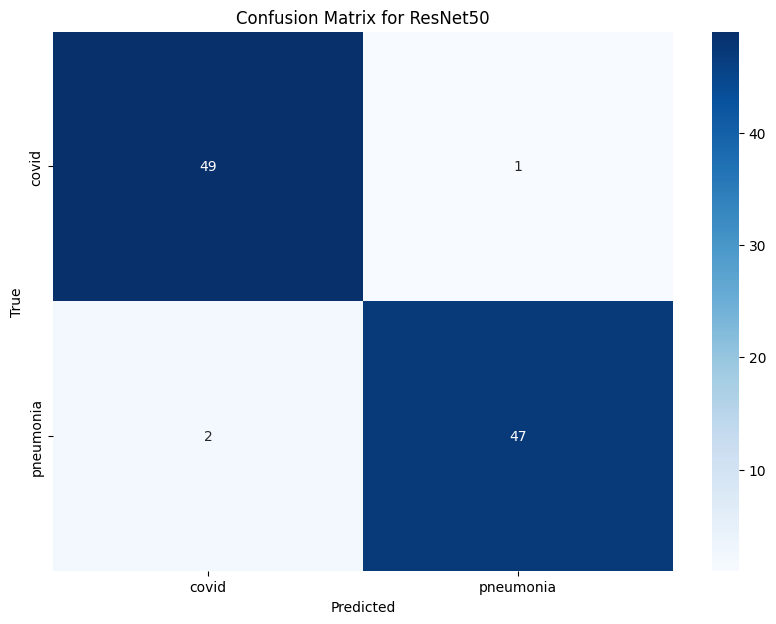

In [16]:
# Train ResNet50 Model
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
# Freeze the base model layers
base_model_resnet.trainable = False
history_resnet, time_resnet, conf_matrix_resnet, report_resnet, Y_test_resnet, Y_pred_resnet = build_and_train_model(base_model_resnet, X_train, Y_train, X_val, Y_val, X_test, Y_test, labels, 'ResNet50')

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 423ms/step - accuracy: 0.7194 - loss: 9.9125 - val_accuracy: 0.9495 - val_loss: 1.5002
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 362ms/step - accuracy: 0.9080 - loss: 2.1935 - val_accuracy: 0.9697 - val_loss: 1.4275
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 363ms/step - accuracy: 0.9561 - loss: 1.2428 - val_accuracy: 0.9697 - val_loss: 1.2837
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 355ms/step - accuracy: 0.9350 - loss: 1.0125 - val_accuracy: 0.9798 - val_loss: 0.8215
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 362ms/step - accuracy: 0.9502 - loss: 0.7503 - val_accuracy: 0.9596 - val_loss: 1.5027


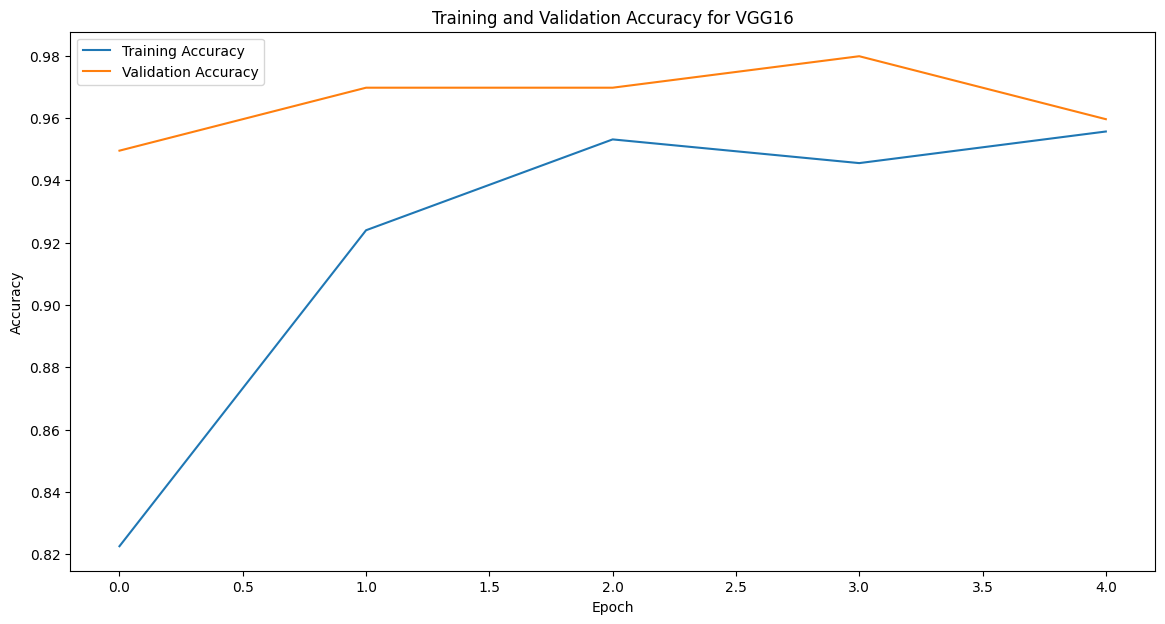

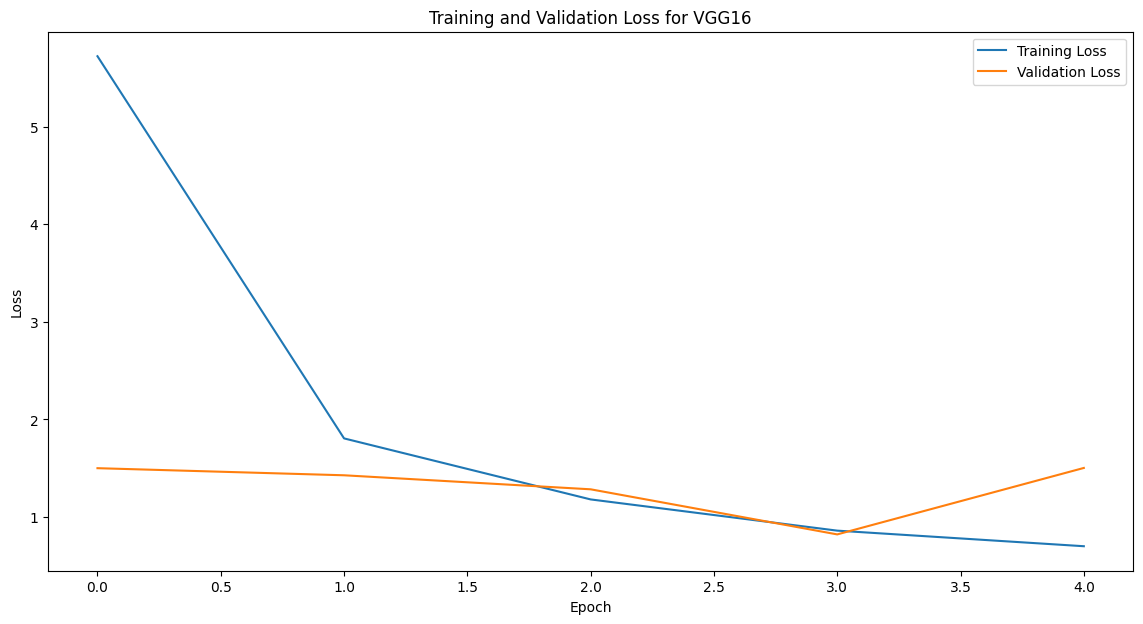

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - accuracy: 0.9443 - loss: 0.1674
Final Test Accuracy: 0.9596
Final Test Loss: 0.1150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step
Classification Report for VGG16:
              precision    recall  f1-score   support

       covid       0.96      0.96      0.96        50
   pneumonia       0.96      0.96      0.96        49

    accuracy                           0.96        99
   macro avg       0.96      0.96      0.96        99
weighted avg       0.96      0.96      0.96        99



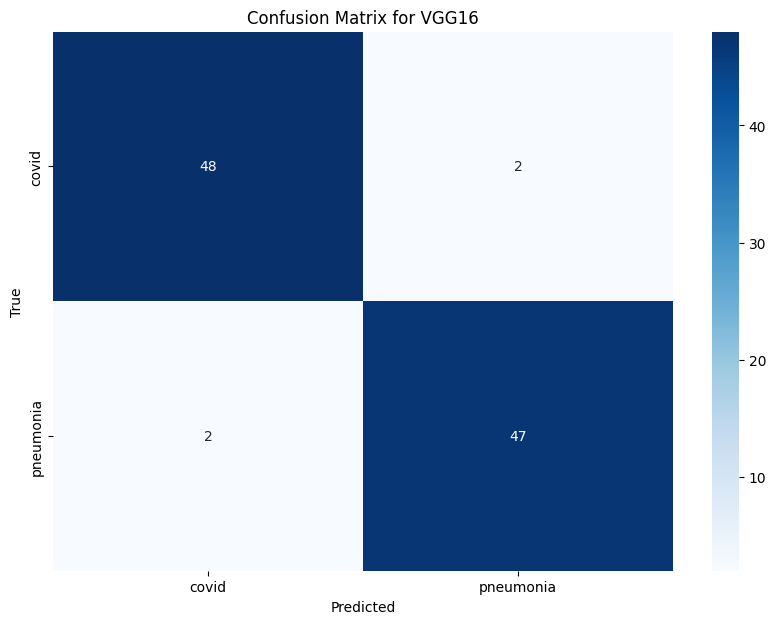

In [20]:
# Train VGG16 Model
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
base_model_vgg.trainable = False
history_vgg, time_vgg, conf_matrix_vgg, report_vgg, Y_test_vgg, Y_pred_vgg = build_and_train_model(base_model_vgg, X_train, Y_train, X_val, Y_val, X_test, Y_test, labels, 'VGG16')

In [22]:
def calculate_metrics(conf_matrix, Y_test, Y_pred_classes):
    # Sensitivity (Recall)
    sensitivity = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)

    # Specificity
    specificity = []
    for i in range(len(conf_matrix)):
        true_negatives = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))
        false_positives = np.sum(np.delete(conf_matrix, i, axis=0)[:, i])
        specificity.append(true_negatives / (true_negatives + false_positives))

    # Cohen's Kappa
    kappa = cohen_kappa_score(Y_test, Y_pred_classes)

    # Classification Report (F1-score included)
    class_report_dict = classification_report(Y_test, Y_pred_classes, target_names=labels, output_dict=True)
    f1_score = {label: class_report_dict[label]['f1-score'] for label in labels}

    return sensitivity, specificity, f1_score, kappa

sensitivity_resnet, specificity_resnet, f1_score_resnet, kappa_resnet = calculate_metrics(conf_matrix_resnet, Y_test_resnet, Y_pred_resnet)
sensitivity_vgg, specificity_vgg, f1_score_vgg, kappa_vgg = calculate_metrics(conf_matrix_vgg, Y_test_vgg, Y_pred_vgg)

In [23]:
print("ResNet50 Metrics:")
print(f"Sensitivity (Recall): {sensitivity_resnet}")
print(f"Specificity: {specificity_resnet}")
print(f"F1 Score: {f1_score_resnet}")
print(f"Cohen's Kappa: {kappa_resnet}")

print("\nVGG16 Metrics:")
print(f"Sensitivity (Recall): {sensitivity_vgg}")
print(f"Specificity: {specificity_vgg}")
print(f"F1 Score: {f1_score_vgg}")
print(f"Cohen's Kappa: {kappa_vgg}")

ResNet50 Metrics:
Sensitivity (Recall): [0.98       0.95918367]
Specificity: [0.9591836734693877, 0.98]
F1 Score: {'covid': 0.9702970297029702, 'pneumonia': 0.9690721649484536}
Cohen's Kappa: 0.9393753827311696

VGG16 Metrics:
Sensitivity (Recall): [0.96       0.95918367]
Specificity: [0.9591836734693877, 0.96]
F1 Score: {'covid': 0.96, 'pneumonia': 0.9591836734693877}
Cohen's Kappa: 0.9191836734693878


In [24]:
import numpy as np
import hashlib

def get_image_hash(image_array):
    """Compute hash of an image numpy array to detect duplicates."""
    hasher = hashlib.md5()
    hasher.update(image_array.tobytes())  # Convert image array to bytes
    return hasher.hexdigest()

def check_duplicate_images(X_train, X_val, X_test):
    """Checks for duplicate images across train, validation, and test sets."""
    sets = {'train': X_train, 'val': X_val, 'test': X_test}
    hash_dict = {}

    for split, images in sets.items():
        for i, img in enumerate(images):
            img_hash = get_image_hash(img)
            if img_hash in hash_dict:
                print(f"⚠️ Duplicate image found between {split} and {hash_dict[img_hash]}!")
            hash_dict[img_hash] = split  # Store where the hash was first seen

    print("✅ No duplicate images found between train, val, and test sets!")

# Run check
check_duplicate_images(X_train, X_val, X_test)

✅ No duplicate images found between train, val, and test sets!


In [25]:
import pynvml

pynvml.nvmlInit()
deviceCount = pynvml.nvmlDeviceGetCount()
for i in range(deviceCount):
    handle = pynvml.nvmlDeviceGetHandleByIndex(i)
    print(f"Device {i}: {pynvml.nvmlDeviceGetName(handle).decode()}")
pynvml.nvmlShutdown()

AttributeError: 'str' object has no attribute 'decode'